In [147]:
# import libraries 
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter
import numpy as np
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')

In [126]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [ ]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../utils")

from construct_model import *
from text_pre_processor import *

%aimport construct_model
%aimport text_pre_processor

In [3]:
posts_df = pd.read_pickle('../data/interum/text_target.pkl')

In [4]:
# convert into features and target 
feature = posts_df['cleaned_text']
label = posts_df['target']

## we will focus on:

* MultinomialNB
* RandomForest
* LogisticRegression

## Logistic regression 

In [13]:
# after paramater tuning logistic regression works best with slight tuning for tfidvector
tfidf_vect_lg = TfidfVectorizer(ngram_range=(1,2),max_df=0.5,min_df=6, max_features=9000)
# hyperparamater from extensive model gridsearch/randomsearch
lg = LogisticRegression(C=2, penalty='l1',random_state=42)

In [14]:
# run model and get results for logistic regression 
lg_model = ConstructModel([tfidf_vect_lg, lg],feature,label)

In [31]:
# best estimator 
lg_estimator = lg_model.pipe[1]

In [47]:
# final predictions
lg_pred= lg_model._X_test.apply(lg_model.get_prediction).apply(lambda x: x[0])

In [15]:
# check model accuracy score for test and train 
lg_model.get_score()

Train Score:	 0.8931149705045172
Test Score:	 0.8150470219435737


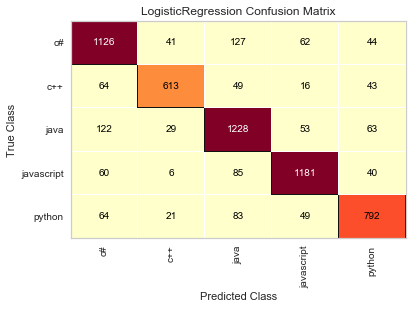

In [16]:
# check confusion matrix
lg_model.get_confusion_matrix()

## RandomForest 

In [49]:
# after paramater tuning, a default settings works best
tfidf_vect_rf= TfidfVectorizer()
# hyperparamater from extensive model gridsearch/randomsearch
rf = RandomForestClassifier(
    criterion='gini', max_depth=1500, max_leaf_nodes=1000, 
    min_samples_leaf=2, min_samples_split=2, n_estimators=1000,random_state = 42)

In [50]:
# run model and get results for random forest 
rf_model = ConstructModel([tfidf_vect_rf,rf],feature,label)

In [ ]:
rf_estimator = rf_model.pipe[1]

In [53]:
# final predictions
rf_pred= rf_model._X_test.apply(rf_model.get_prediction).apply(lambda x: x[0])

In [55]:
rf_feature = rf_estimator.feature_importances_

In [21]:
# check model accuracy score for test and train 
rf_model.get_score()

Train Score:	 0.907553318757477
Test Score:	 0.8015179013364131


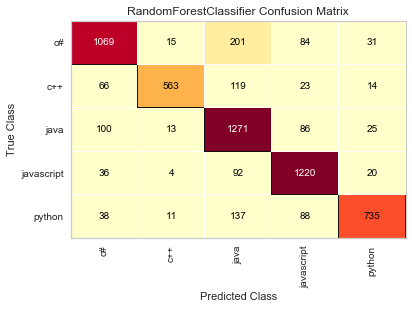

In [22]:
# check confusion matrix
rf_model.get_confusion_matrix()

## multinominalNB 

In [23]:
# after paramater tuning, a default settings works best
tfidf_vect_nb= TfidfVectorizer()
# hyperparamater from extensive model gridsearch/randomsearch
nb = MultinomialNB(alpha = 0.1,fit_prior=False)

In [24]:
# run model and get results for nb
nb_model = ConstructModel([tfidf_vect_nb,nb],feature,label)

In [59]:
nb_estimator = nb_model.pipe[1]
# final predictions
nb_pred= nb_model._X_test.apply(nb_model.get_prediction).apply(lambda x: x[0])

In [25]:
# check model accuracy score for test and train 
nb_model.get_score()

Train Score:	 0.9083783672290747
Test Score:	 0.8130671506352087


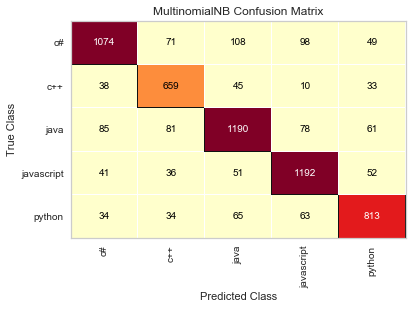

In [26]:
# check confusion matrix
nb_model.get_confusion_matrix()

### Combine 3 models  

  - Based upon the confusion matrix results, certain models do a better job predict certain label 
  
  - Combine and get majority vote as final results 

In [65]:
def majority_vote(lg_pred,rf_pred,nb_pred):
    '''
    inputs:
    lg_pred:
    rf_pred:
    nb_pred:
    returns:
    combined prediction result 
    '''
    combined = []
    predicted = zip(lg_pred,rf_pred,nb_pred)
    for p in predicted:
        votes = Counter(p)
        most = max(votes.values())
        if most >1:
            combined.append(list(votes.keys())[list(votes.values()).index(most)])
        else:
            combined.append(np.random.choice(list(votes.keys()),1)[0])
    return combined
    

In [66]:
combined_pred = majority_vote(lg_pred,rf_pred,nb_pred)

In [68]:
accuracy_score(lg_model._y_test,combined_pred)

0.8313809602375846

In [79]:
lg_estimator.classes_+'_True'

array(['c#_True', 'c++_True', 'java_True', 'javascript_True',
       'python_True'], dtype=object)

In [83]:
cm = confusion_matrix(lg_model._y_test,combined_pred, labels= lg_estimator.classes_)
cm_df = pd.DataFrame(cm, columns=lg_estimator.classes_+' Pred',
             index=lg_estimator.classes_+' True')

In [86]:
cm_df

,c# Pred,c++ Pred,java Pred,javascript Pred,python Pred
c# True,1123,39,129,74,35
c++ True,58,625,61,14,27
java True,88,27,1271,64,45
javascript True,37,12,75,1214,34
python True,43,13,87,60,806


In [109]:
def coef_features(modelname, lg = True):
    '''
    inputs:
    modelname: models  
    lg: if it is linear regression if not it is nb
    returns:
    a dictionary of coefs and featurename 
    '''
    labels = modelname.classes_  # label 
    if lg:
        coefs = modelname[1].coef_
    else:
        coefs = modelname[1].feature_log_prob_
    featurenames = modelname[0].get_feature_names()
    coef_dict={}
    for i, l in enumerate(labels):
        coef_dict[l]=[]
        for c, f in zip(coefs[i],featurenames):
            if c:
                coef_dict[l].append((f,c))
    return coef_dict   

def top_10_feature(coef_dict, lg = True):
    '''
    input:
    coef_dict: a dictionary of coefs and featurename from coef_features function
    lg: if true it is logistic regression otherwise nb 
    returns:
    a data frame of top 10 most important features for each classes 
    '''
    top_10 = {}
    for l in coef_dict.keys():
        top_10[l] = sorted(coef_dict[l], key = lambda x: x[1], reverse = True)[:10]
        top_10[l] = [x[0] for x in top_10[l]]
    df = pd.DataFrame(top_10)
    if lg:
        df.columns = df.columns + '_lg'
    else:
        df.columns = df.columns + '_nb'
    return df

In [113]:
lg_coef_f = coef_features(lg_model.pipe)
nb_coef_f = coef_features(nb_model.pipe,lg=False)

In [114]:
lg_f = top_10_feature(lg_coef_f)
lg_f

,c#_lg,c++_lg,java_lg,javascript_lg,python_lg
0,writeline,boost,jvm,jquery,django
1,net,cout,jdk,backbone,numpy
2,dispose,std,jsp,console log,py
3,resharper,qt,system println,angularjs,def
4,window form,cpp,println,prototype,pythonic
5,linq,stl,spring,ecmascript,pep
6,msdn,gcc,jar,alert,matplotlib
7,ienumerable,int main,junit,browser,urllib
8,xaml,header file,hibernate,jslint,sqlalchemy
9,wpf,std string,jdbc,angular,typeerror


In [115]:
nb_f = top_10_feature(nb_coef_f,lg=False)
nb_f

,c#_nb,c++_nb,java_nb,javascript_nb,python_nb
0,string,std,string,function,list
1,use,int,class,jquery,file
2,public,use,use,use,use
3,class,const,file,var,print
4,net,function,method,div,py
5,get,class,public,page,like
6,method,code,new,like,way
7,new,vector,get,html,self
8,code,foo,like,script,get
9,list,string,way,way,line


In [116]:
# randomforest importance 

In [119]:
importance_score_rf = rf_estimator.feature_importances_
feature_name_rf = rf_model.pipe[0].get_feature_names()
importance_f_rf =[]
for c, f in zip(importance_score_rf,feature_name_rf):
    if c:
        importance_f_rf.append((f,c))
top_10 = sorted(importance_f_rf, key=lambda x: x[1], reverse = True)[:10]

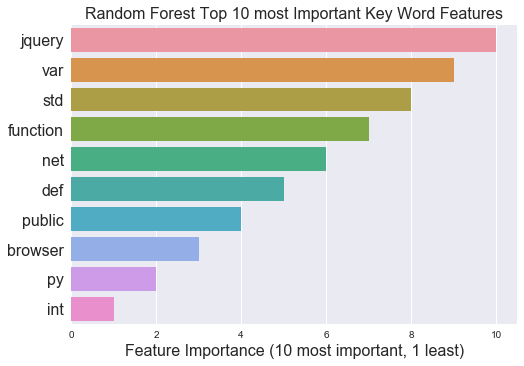

In [151]:
sns.barplot(x= np.arange(10,0,-1), y = [f[0] for f in top_10])
plt.xlabel('Feature Importance (10 most important, 1 least)', size = 16)
plt.yticks(size=16)
plt.title('Random Forest Top 10 most Important Key Word Features', size = 16)
plt.show()